In [1]:
from __future__ import division, print_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
import george
from george import kernels

import pandas as pd

from astropy.stats import median_absolute_deviation as MAD
import glob
import emcee

import tqdm

In [22]:
# fn = '../data/215900519P-ep20160806.csv'
fns = glob.glob('../data/*.csv')
print(np.shape(fns))
fn = fns[4]
df = pd.read_csv(fn, skiprows=39)
df['time'] = df.t - df.t[0]
df['flux'] = df.fdt_t_roll_2D/ np.median(df.fdt_t_roll_2D) - 1.0
df['ferr'] = np.ones_like(df.t) * MAD(df.flux) /20

print(np.shape(df.time), np.shape(df.flux), np.shape(df.ferr))

(5,)
(3475,) (3475,) (3475,)


(-0.03, 0.03)

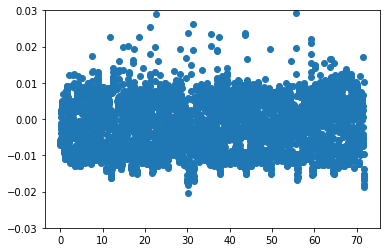

In [23]:
plt.scatter(df.time,df.flux)
# plt.xlim(0,5)
plt.ylim(-0.03,0.03)

In [24]:
y = df.loc[(df.time < 15) * (np.abs(df.flux)<0.02),'flux']
yerr = df.loc[(df.time < 15) * (np.abs(df.flux)<0.02),'ferr']
t = df.loc[(df.time < 15) * (np.abs(df.flux)<0.02),'time']


print(np.shape(t)), print(np.shape(yerr)), print(np.shape(t))



(716,)
(716,)
(716,)


/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(None, None, None)

In [25]:
A = 0.001
l = 10.
G = 2.0
sigma = 0.001
P = 2.0
kernel= A * kernels.ExpSquaredKernel(l) * kernels.ExpSine2Kernel(G, P) + kernels.WhiteKernel(sigma)   
# kernel= A * kernels.ExpSine2Kernel(G, P) + kernels.WhiteKernel(sigma)   
                  

In [26]:

gp = george.GP(kernel, )#solver=george.HODLRSolver)
gp.compute(t, yerr=yerr)
print(gp.lnlikelihood(y))
print(gp.grad_lnlikelihood(y))


1759.84329312
[ -12.65082338    4.51216303   -8.73800186   65.66771532 -328.58545937]


In [27]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p, yval=y):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(yval, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p, yval=y):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(yval, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t, yerr=yerr)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.kernel.vector
results = op.minimize(nll, p0, jac=grad_nll)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(y))

1759.84329312
3284.01713594


In [28]:
print(results)

      fun: -3284.017135938245
 hess_inv: array([[  1.50783522e-02,   4.74758608e-03,  -2.67690890e-03,
         -1.54850307e-05,  -1.52031424e-04],
       [  4.74758608e-03,   1.12513245e-02,   6.89448666e-04,
          3.21149438e-06,   6.75894597e-04],
       [ -2.67690890e-03,   6.89448666e-04,   1.07893153e-02,
         -1.33044179e-05,  -3.98603278e-03],
       [ -1.54850307e-05,   3.21149438e-06,  -1.33044179e-05,
          4.63135012e-06,   1.62926967e-05],
       [ -1.52031424e-04,   6.75894597e-04,  -3.98603278e-03,
          1.62926967e-05,   6.74062852e-03]])
      jac: array([  1.25112147e-06,  -3.16829029e-06,  -3.73151111e-07,
        -2.72527507e-05,   2.69679598e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 108
      nit: 30
     njev: 96
   status: 2
  success: False
        x: array([-10.3202286 ,   1.68722503,   4.36694049,   0.8625197 , -13.04212667])


In [29]:
x = np.linspace(0, 15, 500)
mu, cov = gp.predict(y, x)
std = np.sqrt(np.diag(cov))

In [30]:
mup, covp = gp.predict(y, t + (t*0.0001)) # for some reason trying to predict at exactly the same time is a problem
stdp = np.sqrt(np.diag(covp))
flares = y > mup + (stdp*1.5)
tflares = np.where(flares,t,np.nan)
yflares = np.where(flares,y,np.nan)

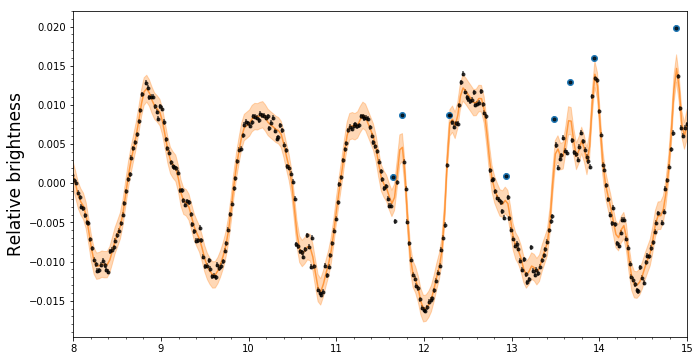

In [31]:
fig, ax = plt.subplots(1,1,figsize=[11,6], )

ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0,alpha=0.7)
ax.plot(tflares, yflares, 'o-')
ax.fill_between(x,mu-std,mu+std, color="#ff7f0e", alpha=0.3,
                edgecolor="none")
ax.plot(x,mu,color="#ff7f0e", alpha=0.7)
ax.set_xlim(8,15)

ax.set_ylabel('Relative brightness', fontsize=17)
ax.minorticks_on()

In [32]:
gp = george.GP(kernel, )#solver=george.HODLRSolver)
gp.compute(t[~flares], yerr=yerr[~flares])
print(gp.lnlikelihood(y[~flares]))
print(gp.grad_lnlikelihood(y[~flares]))

# You need to compute the GP once before starting the optimization.
gp.compute(t[~flares])

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y[~flares]))

# Run the optimization routine.
p0 = gp.kernel.vector
results = op.minimize(nll, p0, jac=grad_nll,args=y[~flares])

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(y[~flares]))

3353.59515131
[ -29.13751129   23.25880475  -79.63263599   80.05249969 -145.66466578]
3360.58332293
3455.39976556


In [33]:
x = np.linspace(0, 15, 500)
mu, cov = gp.predict(y[~flares], x)
std = np.sqrt(np.diag(cov))

In [34]:
mup, covp = gp.predict(y[~flares], t + (t*0.0001)) # for some reason trying to predict at exactly the same time is a problem
stdp = np.sqrt(np.diag(covp))
flares = y > mup + (stdp*2.5)
tflares = np.where(flares,t,np.nan)
yflares = np.where(flares,y,np.nan)

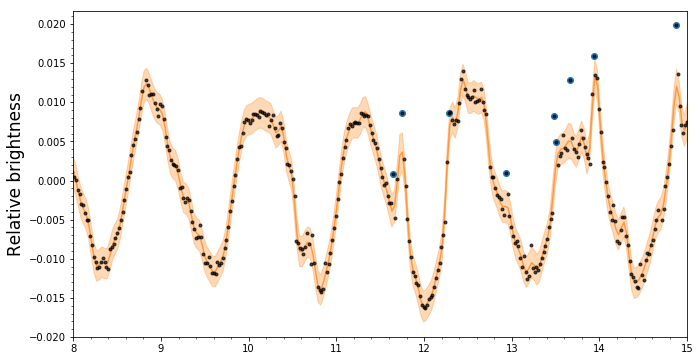

In [35]:
fig, ax = plt.subplots(1,1,figsize=[11,6], )

ax.errorbar(t, y, yerr=0, fmt=".k", capsize=0,alpha=0.7)
ax.plot(tflares, yflares, 'o')
ax.fill_between(x,mu-std*2,mu+std*2, color="#ff7f0e", alpha=0.3,
                edgecolor="none")
ax.plot(x,mu,color="#ff7f0e", alpha=0.7)
ax.set_xlim(8,15)

ax.set_ylabel('Relative brightness', fontsize=17)
ax.minorticks_on()

In [36]:
(np.e**gp.kernel[:])

array([  3.04257446e-05,   1.19128500e+01,   1.60745179e+02,
         3.57219316e+00,   7.15489511e-07])

In [37]:
gp.kernel.vector

array([-10.40022145,   2.47761765,   5.07982038,   1.27317974, -14.1502989 ])

In [38]:
nwalkers, ndim = 16, len(gp.kernel.vector)

In [85]:
def angus_kernel(theta):
    """
    use the kernel that Ruth Angus uses. Be sure to cite her
    """
    theta = np.exp(theta)
    A = theta[0]
    l = theta[1]
    G = theta[2]
    sigma = theta[4]
    P = theta[3]
    kernel = (A * kernels.ExpSquaredKernel(l) *
              kernels.ExpSine2Kernel(G, P) +
              kernels.WhiteKernel(sigma)
              )
    return kernel

def lnprob(p, time, y, yerr):
    # Trivial improper prior: uniform in the log.
    # from DFM george user guide

    if np.any((-p < -20) + (p > 10)):
        return -np.inf

    lnprior = 0.0

    kernel = angus_kernel(p)
    gp = george.GP(kernel)
    gp.compute(time, yerr)

    return lnprior + gp.lnlikelihood(y, quiet=True)

In [86]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                    args=[
                                        t,
                                        y,
                                        yerr,
                                    ])

In [87]:
p0 = (np.repeat(gp.kernel.vector, nwalkers) *
      np.random.random(size=ndim * nwalkers))
p0 = p0.reshape(ndim, nwalkers).T

In [88]:
p0, _, _ = sampler.run_mcmc(p0, 1)

In [128]:
samples = sampler.run_mcmc(p0, 2000)

(array([ 1015.,  4138.,   471.,     0.,     0.,     0.,     0.,     0.,
          283.,  5341.]),
 array([ 1.04477958,  1.06415793,  1.08353629,  1.10291464,  1.12229299,
         1.14167134,  1.16104969,  1.18042805,  1.1998064 ,  1.21918475,
         1.2385631 ]),
 <a list of 10 Patch objects>)

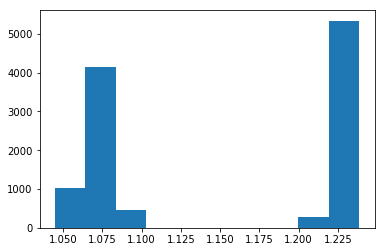

In [151]:
plt.hist(np.e**sampler.chain[:,1500:,3].flatten())

,0,1,2,3,4
0,-3.242322,1.844051,2.149511,0.723027,-9.602036
1,-4.222134,1.833992,2.893335,0.684861,-9.996093
2,-5.991782,2.115890,2.310145,0.768939,-10.746850
3,-3.242322,1.844051,2.149511,0.723027,-9.602036
4,-3.242322,1.844051,2.149511,0.723027,-9.602036
5,-4.398130,1.832186,3.026943,0.678006,-10.066875
6,-4.366205,1.837516,2.989887,0.669114,-10.059891
7,-4.366205,1.837516,2.989887,0.669114,-10.059891
8,-4.059268,1.726735,2.085253,0.530179,-10.996365
9,-5.812108,0.545816,1.960960,0.491039,-11.446883
